#  Case study: Names mapping

## Inspecting the dataset

In [53]:
import numpy as np
import pandas as pd
from time import time

df = pd.read_excel('./data/Case_study_names_mapping.xlsx')
df.sample(n=10)

Raw name  Mapped name
2654                                  AOC          NaN
3437  ASAHI DIAMOND INDUSTRIAL EUROPE SAS          NaN
3425           AS SCIENTIFIC PRODUCTS LTD          NaN
4653                          AVTRADE LTD          NaN
3139                   AREA ETUDES NANTES          NaN
2373                     ANADEF C/O ADERA          NaN
3529               ASIS INTERNATIONAL INC          NaN
1728                 ALLEGRA OF CHANTILLY          NaN
1497                        ALAIN ERNOULT          NaN
320                              AC HOTEL          NaN

The dataset is made of multiple company names. 

Some irregularities require a cleaning:
 - inconsistent case, 
 - multiple languages (German, Spanish, French, English), 
 - badly encoded characters,
 - useless characters (., -, ...)
 - stop words (S.L., LTD...)

#### Inconsistent case

In [54]:
df['Clean name'] = df['Raw name'].str.upper()
df['Clean name'].head()

0        "ACCESOS NORMALIZADOS, SL"
1     "ALTAIX ELECTRONICA , S.A.L."
2    "ANTALA LOCKS & ACCESORIS, SL"
3                     "ANTERAL, SL"
4      "ARQUIMEA INGENIERIA , S.L."
Name: Clean name, dtype: object

#### Normalizing characters



In [55]:
from unidecode import unidecode

accented_name = df.iloc[4003]['Clean name']

print("Original name: ", accented_name)
print("Decoded name: ", unidecode(accented_name))

df['Clean name'] = df['Clean name'].apply(unidecode)

Original name:  ATLANTIK-BRÃCKE EV
Decoded name:  ATLANTIK-BRACKE EV


#### Handling non-literal characters

In [56]:
import re

df['Clean name'] = df['Clean name'].apply(lambda s: re.sub(r'[^a-zA-Z0-9 ]', lambda s : '', s))
df[['Raw name', 'Clean name']].head(5)

Raw name                  Clean name
0      "ACCESOS NORMALIZADOS, SL"     ACCESOS NORMALIZADOS SL
1   "ALTAIX ELECTRONICA , S.A.L."     ALTAIX ELECTRONICA  SAL
2  "ANTALA LOCKS & ACCESORIS, SL"  ANTALA LOCKS  ACCESORIS SL
3                   "ANTERAL, SL"                  ANTERAL SL
4    "ARQUIMEA INGENIERIA , S.L."     ARQUIMEA INGENIERIA  SL

#### Defining stop words

A lot of names include abbreviations or descriptions which are not absolutely relevant.

In [57]:
from collections import Counter

word_count = Counter()
df['Clean name'].str.split().apply(word_count.update)

word_count.most_common()[:30]

[('GMBH', 798),
 ('LTD', 234),
 ('DE', 162),
 ('CO', 140),
 ('INC', 131),
 ('ASSOCIATION', 126),
 ('SL', 123),
 ('KG', 114),
 ('SA', 113),
 ('SAS', 95),
 ('AUTOHAUS', 93),
 ('SERVICES', 84),
 ('LIMITED', 80),
 ('GROUP', 71),
 ('FRANCE', 66),
 ('A', 61),
 ('TECHNOLOGIES', 59),
 ('UND', 57),
 ('SYSTEMS', 57),
 ('SOLUTIONS', 56),
 ('CONSULTING', 55),
 ('LLC', 49),
 ('ADVANCED', 45),
 ('SARL', 44),
 ('ASOCIACION', 44),
 ('ENGINEERING', 42),
 ('AG', 41),
 ('FUER', 40),
 ('AKADEMIE', 36),
 ('ET', 35)]

For example, GMBH (Gesellschaft mit beschränkter Haftung) is a special kind of society. Keeping this term could lead to irrelevant mapping, but it may be an interesting indicator for the company's region.

The choice mostly depends on the next steps, so I wont linger more on this part.

In [58]:
stop_words = word_count.most_common()[:30]+[('ENGINEERING', 0), ('SERVICES', 0)]
stop_words = r'\b|\b'.join([s for s, _ in stop_words])
df['Clean name'] = df['Clean name'].apply(lambda s: re.sub(r'\b'+stop_words+r'\b', lambda s: '', s))
df[['Raw name', 'Clean name']].head()

Raw name                Clean name
0      "ACCESOS NORMALIZADOS, SL"     ACCESOS NORMALIZADOS 
1   "ALTAIX ELECTRONICA , S.A.L."   ALTAIX ELECTRONICA  SAL
2  "ANTALA LOCKS & ACCESORIS, SL"  ANTALA LOCKS  ACCESORIS 
3                   "ANTERAL, SL"                  ANTERAL 
4    "ARQUIMEA INGENIERIA , S.L."     ARQUIMEA INGENIERIA

## Choosing a distance


### Levenshtein

Nothing but a distance is needed in order to cluster anything.

When dealing with text, the Levenshtein distance seems appropriate. It computes the number of modifications needed in order to get a sentence from another. However, it requires to compute a $n_{rows}^2$ matrix and the result is not so clear.

In [59]:
from Levenshtein import distance as lev_dist
from scipy.spatial.distance import pdist, squareform

partial_df = df['Clean name']

t = time()

reshaped_partial_df = partial_df.to_numpy().reshape((-1, 1))

def dist(a, b):
    # needed due to shape
    return lev_dist(a[0], b[0])

X = pdist(reshaped_partial_df, dist)
X
t_levenshtein = time() - t
print("Levenshtein execution time:", t_levenshtein)

Levenshtein execution time: 35.5463387966156


### TF-IDF, N-gram and cosine angle.

TF-IDF is a method which takes into account the frequency of words within a document and the frequency of words within the all corpus of document.
It favors important words.

With such little documents as names, a solution to extract many "words" is to use character N-grams, that is, all continuous sequence of characters of length at most N. For example, the character 3-grams of McDonald and Macdo are:

`['McD', 'cDo', 'Don', 'ona', 'nal', 'ald']`

`['Mac', 'acd', cdo']`

So, even if 'McDonald' and 'Macdo', as whole words, don't match, taking 3-grams makes them overlap through 'cdo'.

As for the distance, the cosine distance is both quick and easy to understand.

I first wanted to use the awesome_cossim_topn function from sparse_dot_topn, which computes a sparse matrix multiplication, so fast and memory efficient, but it leads to errors with the cluster algorithm.


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sparse_dot_topn import awesome_cossim_topn
from sklearn.metrics.pairwise import cosine_distances


def ngrams(string, n=3):
    string = re.sub(r' ', lambda s: '', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams] 

def multi_ngrams(string):
    string = string.strip()
    return string.split() + ngrams(string, n=3) + ngrams(string, n=2) + ngrams(string, n=4)

t = time()
vectorizer = TfidfVectorizer(analyzer=multi_ngrams)
tf_idf = vectorizer.fit_transform(df['Clean name'])

# X = awesome_cossim_topn(tf_idf, tf_idf.T, 100, 0.8)
X = cosine_distances(tf_idf)

X
t_tfidf = time() - t

print("TF-IDF execution time: ", t_tfidf)
print("Levenshtein is {:.0f} times slower than TF-IDF.".format(t_levenshtein/t_tfidf))

TF-IDF execution time:  5.324607849121094
Levenshtein is 7 times slower than TF-IDF.


### Decision

Levenshtein distance is quite hard to interpret, doesn't take into account the frequency of words, is slow, and requires a $n_{rows}^2$ matrix.

TF-IDF is globally better.

## Clustering

One of the most powerful and scalable clustering algorithm is HDBSCAN, which is almost as fast as DBSCAN and hierarchical. It finds the number of clusters itself, and handle names that cannot be clustered.

In [71]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric="precomputed", cluster_selection_method='leaf', allow_single_cluster=True, min_samples=1)
hdbscan.HDBSCAN()

cluster_labels = clusterer.fit_predict(X)
print('Number of clusters found: ', max(cluster_labels))

Number of clusters found:  1196


### Analyzing the results

HDBSCAN gives both labels and the probability of each name to belong to its cluster.

In [72]:
df['cluster'] = cluster_labels
df['prob'] = clusterer.probabilities_
df[['Raw name', 'cluster', 'prob']].sort_values('cluster', ascending=False)

Raw name  cluster  prob
1968       ALTEN TECHNOLOGY GMBH     1196   1.0
1967           ALTEN TECHNOLOGIE     1196   1.0
338              ACAL TECHNOLOGY     1195   0.0
865    ADVANCED TECHNOLOGY GROUP     1195   1.0
1485               AL TECHNOLOGY     1195   0.0
...                          ...      ...   ...
2308      AMPLIFON GROUPE FRANCE       -1   0.0
2309     AMPLIFY INNOVATION GMBH       -1   0.0
2315                 AMPLYFI LTD       -1   0.0
1498   ALAIN SCHEPENS CLASS MOTO       -1   0.0
3761  ASSOCIATION MOONLIGHT ROSE       -1   0.0

[4895 rows x 3 columns]

The given probability seems strange, since some clustered names have 0 probability of belonging to their cluster.

Another score could be preferred.

We can look at some examples:

In [108]:
df[['Raw name', 'Clean name', 'prob']][df.cluster == 2].sort_values('Raw name')

Raw name Clean name  prob
2940       AQMO       AQMO   1.0
2941  AQMO-ISSA   AQMOISSA   1.0

The number of unclustered names is given by:

In [116]:
unclustered_names = len(df[df.cluster==-1])
print("There is {} unclustered names, that is {:0.2f} % of the dataset.".format(unclustered_names, unclustered_names/len(df)))

There is 1589 unclustered names, that is 0.32 % of the dataset.


In [218]:
df['Mapped name'] = df.groupby('cluster')['Clean name'].transform(lambda x:x.value_counts().index[0]).to_frame()
df['Mapped name'] = np.where(df.cluster == -1, df['Clean name'], df['Mapped name'])

df[['Raw name', 'Mapped name', 'prob', 'cluster']][df.cluster == 5]

Raw name          Mapped name  prob  cluster
2655                  AOIP  AOIP  SOCIT ANONYME   1.0        5
2656  AOIP - SOCIT ANONYME  AOIP  SOCIT ANONYME   0.0        5
2657              AOIP SAS  AOIP  SOCIT ANONYME   1.0        5

### Refining the clusters with Hierarchy

HDBSCAN also creates a single linkage tree which represents the cluster hierarchy, and which can be used in order to get smaller or bigger clusters, according to the maximum distance allowed to merge two clusters.

Let's visualize a truncated version of the tree:

<AxesSubplot:ylabel='distance'>

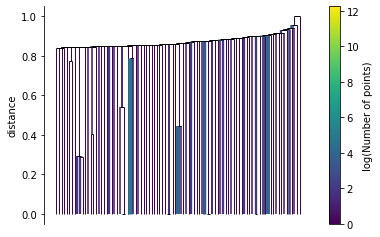

In [119]:
clusterer.single_linkage_tree_.plot(truncate_mode='level', p=80)

The plot indicates that:
- there are a lot of clusters, 
- these clusters are not easily merged: company names are globally different from each other,
- there is no precise position threshold to find balance between number of clusters and the quality of them.

In order to get other clusters, we specify a distance to the single linkage tree.

In [226]:
cluster_labels_cut = clusterer.single_linkage_tree_.get_clusters(0.3, min_cluster_size=2)

df['cluster cut'] = cluster_labels_cut

print("Number of new clusters found: ", max(cluster_labels_cut))

df[df.cluster_cut == 52].sort_values('cluster cut', ascending=False)

Number of new clusters found:  680


Raw name    Mapped name     Clean name  cluster    prob  \
314        ABYLSEN  ABYLSEN GAMMA        ABYLSEN        7  1.0000   
315  ABYLSEN GAMMA  ABYLSEN GAMMA  ABYLSEN GAMMA        7  0.9793   
316  ABYLSEN SIGMA  ABYLSEN GAMMA  ABYLSEN SIGMA        7  1.0000   

     cluster_bis Mapped name bis  cluster bis  
314           52   ABYLSEN GAMMA           52  
315           52   ABYLSEN GAMMA           52  
316           52   ABYLSEN GAMMA           52

Through some observations, the new clusters seems more precise, but the cut value is not precise, and more names are unclustered.

In [240]:
df['Mapped name cut'] = df.groupby('cluster cut')['Clean name'].transform(lambda x:x.value_counts().index[0]).to_frame()
df['Mapped name cut'] = np.where(df.cluster == -1, df['Clean name'], df['Mapped name'])

df[['Raw name', 'Mapped name cut', 'cluster cut']][df['cluster cut'] == 11]

Raw name     Mapped name bis  cluster bis
26    A MAI INTERNATIONAL  AMAI INTERNATIONAL           11
2117   AMAI INTERNATIONAL  AMAI INTERNATIONAL           11

## Performance analysis

To run the following, run in the Docker container:

`python -m cProfile -o profile.out src/main.py data/Case_study_names_mapping.xlsx`

In [25]:
import pstats
from pstats import SortKey

p = pstats.Stats('profile.out')

In [26]:
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats(10)


Wed Apr 28 11:29:40 2021    profile.out

         3749917 function calls (3723412 primitive calls) in 44.955 seconds

   Ordered by: call count
   List reduced from 6192 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
513997/513994    0.205    0.000    0.287    0.000 {built-in method builtins.isinstance}
234355/234351    0.061    0.000    0.064    0.000 {method 'join' of 'str' objects}
   207862    0.068    0.000    0.072    0.000 {built-in method builtins.getattr}
   183321    0.033    0.000    0.033    0.000 {method 'append' of 'list' objects}
127974/120051    0.049    0.000    0.054    0.000 {built-in method builtins.len}
   100326    0.054    0.000    0.073    0.000 generic.py:30(_check)
    79191    0.017    0.000    0.018    0.000 {built-in method builtins.issubclass}
    78358    0.032    0.000    0.032    0.000 ElementTree.py:1604(_fixname)
    55068    0.010    0.000    0.010    0.000 {built-in method builtins.chr}
    541

Most calls are done in the TF-IDF vectorisation (N-Grams) but are very quick.

In [27]:
p.sort_stats(SortKey.CUMULATIVE).print_stats(20)

Wed Apr 28 11:29:40 2021    profile.out

         3749917 function calls (3723412 primitive calls) in 44.955 seconds

   Ordered by: cumulative time
   List reduced from 6192 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   44.991   22.496 main.py:1(<module>)
   1653/1    0.047    0.000   44.959   44.959 {built-in method builtins.exec}
        1    0.020    0.020   34.587   34.587 main.py:13(main)
        1    0.001    0.001   34.567   34.567 clusterize.py:11(map_names)
      116    0.013    0.000   33.504    0.289 __init__.py:1(<module>)
        1    0.000    0.000   25.016   25.016 clusterize.py:42(clusterize)
        1    0.000    0.000   24.195   24.195 hdbscan_.py:926(fit_predict)
        1    0.005    0.005   24.195   24.195 hdbscan_.py:882(fit)
        1    0.005    0.005   23.996   23.996 hdbscan_.py:332(hdbscan)
        1    0.014    0.014   22.935   22.935 memory.py:351(__call__)
        1    

HDBSCAN is the slowest element of the program, but still performs in seconds, when other algorithm would crash (Affinity Propagation for example). The proper use of sparse matrix could speed up the clustering.


## Next steps

This little project is still drafty regarding:

Overall agorithm:
* The use of dense matrices can be quite memory and time consuming, developping a sparse hierarchical clustering algorithm could increase performance,
* The cut value is not really clear and not user friendly.
* The Mapped name could be more clever than picking the most frequent Clean name.

Script:
* Only default values are used,
* Results must be copied from Docker.

However, names are mapped correctly enough, the probability indicates bad mapping, two levels of clustering are provided, everything is documented, and the most efficient/distributed algorithms are used.

Going beyond:
* When the input file is too big even for HDBSCAN, it could be split in smaller frames and processed individually, at the risk of multiplying clusters.
